In [1]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Homework 6: Predicting Housing Prices

## Due Date: 11:59pm Wednesday, July 22

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators:** *list names here*

## Introduction

In this homework, we will go through the iterative process of specifying, fitting, and analyzing the performance of a  model.  

In the first portion of the assignment, we will guide you through some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Next, you will add a new feature to the dataset before specifying and fitting a linear model to a few features of the housing data to predict housing prices. Finally, we will analyze the error of the model and brainstorm ways to improve the model's performance.

After this homework, you should feel comfortable with the following:

1. Simple feature engineering
1. Using sklearn to build simple and more complex linear models
1. Building a data pipeline using pandas
1. Identifying informative variables through EDA
1. Feature engineering with categorical variables

## Score Breakdown

Question | Points
--- | ---
Question 1 | 2
Question 2a | 2
Question 2b | 2
Question 3 | 1
Question 4a | 1
Question 4b | 2
Question 5a | 1
Question 5b | 1
Question 5c | 2
Question 5d | 2
Question 6a | 1
Question 6b | 1
Question 6c | 1
Question 7a | 1
Question 7b | 2
Question 8a | 1
Question 8b | 1
Question 9 | 4
Total | 28

In [2]:
import numpy as np

import pandas as pd

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Data

The [Ames dataset](http://jse.amstat.org/v19n3/decock.pdf) consists of 2930 records taken from the Ames, Iowa Assessor’s Office describing houses sold in Ames from 2006 to 2010.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.  An explanation of each variable can be found in the included `codebook.txt` file.  The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.  **Some noise has been added to the actual sale price, so prices will not match official records.**

The data are split into training and test sets with 2000 and 930 observations, respectively.

In [3]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)
# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)
# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt`.  **You should take some time to familiarize yourself with the codebook before moving forward.**

In [5]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# Part 1: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (a combination of a KDE, a histogram, a strip plot, and a box plot) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

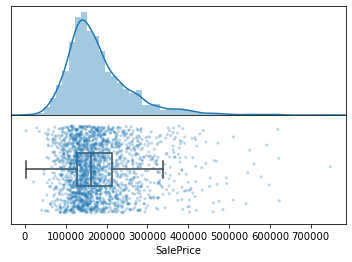

In [6]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'], 
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [7]:
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

## Question 1
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `SalePrice` in the training set is left-skew.
1. The mean of `SalePrice` in the training set is greater than the median.
1. At least 25% of the houses in the training set sold for more than \$200,000.00.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to `True` or `False`.*

<!--
BEGIN QUESTION
name: q1
points: 2
-->

In [8]:
# These should be True or False
q1statement1 = False
q1statement2 = True
q1statement3 = True

In [9]:
grader.check("q1")

All tests passed!

### SalePrice vs Gr_Liv_Area

Next, we visualize the association between `SalePrice` and `Gr_Liv_Area`.  The `codebook.txt` file tells us that `Gr_Liv_Area` measures "above grade (ground) living area square feet."

This variable represents the square footage of the house excluding anything underground.  Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

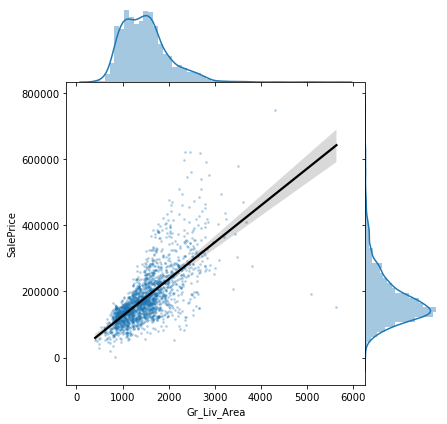

In [10]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

There's certainly an association, and perhaps it's linear, but the spread is wider at larger values of both variables.  Also, there are two particularly suspicious houses above 5000 square feet that look too inexpensive for their size.

We can find the Parcel Indentification Numbers for the two houses with `Gr_Liv_Area` greater than 5000 sqft.

In [11]:
training_data.loc[training_data['Gr_Liv_Area'] > 5000, 'PID'].values

array([908154235, 908154195])

The codebook tells us how to manually inspect the houses using an online database called Beacon. These two houses are true outliers in this data set: they aren't the same time of entity as the rest. They were partial sales, priced far below market value. If you would like to inspect the valuations, follow the directions at the bottom of the codebook to access Beacon and look up houses by PID.

For this assignment, we will remove these outliers from the data. The function `remove_outliers` removes outliers from a data set based off a threshold value of a variable.  For example, `remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)` should return a data frame with only observations that satisfy `Gr_Liv_Area` less than 5000.

In [12]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      a winsorized data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[(data[variable] > lower) & (data[variable] < upper), :]

training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

# Part 2: Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.

### Bathrooms

Let's create a groundbreaking new feature. Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

The actual proof is beyond the scope of this class, but we will use the result in our model.

## Question 2a

Write a function `add_total_bathrooms(data)` that returns a copy of `data` with an additional column called `TotalBathrooms` computed by the formula above.  **Treat missing values as zeros**.  Remember that you can make use of vectorized code here; you shouldn't need any `for` statements. 

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q2a
points: 2
-->

In [13]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    with_bathrooms = with_bathrooms.fillna(0)
    with_bathrooms['TotalBathrooms'] = with_bathrooms[bath_vars].dot(weights)
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

In [14]:
grader.check("q2a")

All tests passed!

<!-- BEGIN QUESTION -->

## Question 2b

Create a visualization that clearly and succintly shows that `TotalBathrooms` is associated with `SalePrice`. Your visualization should avoid overplotting.

<!--
BEGIN QUESTION
name: q2b
points: 2
manual: True
-->

Text(0.5, 1.0, 'Total Bathrooms and Salesprice')

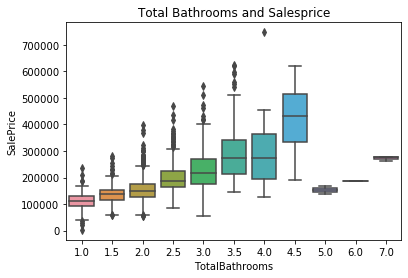

In [15]:
sns.boxplot(x="TotalBathrooms", y="SalePrice", data=training_data)
plt.title('Total Bathrooms and Salesprice')

<!-- END QUESTION -->



# Part 3: Modeling

We've reached the point where we can specify a model. But first, we will load a fresh copy of the data, just in case our code above produced any undesired side-effects. Run the cell below to store a fresh copy of the data from `ames_train.csv` in a dataframe named `full_data`. We will also store the number of rows in `full_data` in the variable `full_data_len`.

In [16]:
# Load a fresh copy of the data and get its length
full_data = pd.read_csv("ames_train.csv")
full_data_len = len(full_data)
full_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700


## Question 3

Now, let's split the data set into a training set and a validation set. We will use the training set to fit our model's parameters, and we will use the validation set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.

"Don't we already have a test set in `ames_test.csv`?" you might wonder. The sale prices for `ames_test.csv` aren't provided, so we're constructing our own validation set for which we know the outputs.

In the cell below, split the data in `full_data` into two DataFrames named `train` and `val`. Let `train` contain 80% of the data, and let `val` contain the remaining 20% of the data. 

Use the `train_test_split` function from `sklearn.model_selection` to perform this split. Use a `random_state` of 42 as an argument to `train_test_split`. 

*The provided tests check that you not only answered correctly, but ended up with the exact same train/validation split as our reference implementation. Later testing is easier this way.*

<!--
BEGIN QUESTION
name: q3
points: 1
-->

In [17]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(full_data, test_size=0.20, random_state=42)

In [18]:
grader.check("q3")

All tests passed!

### Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, it's best to define functions/methods that can apply the pipeline to any dataset.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model". We select a handful of features to use from the many that are available.

In [19]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

Now, we can use `process_data_gm1` to clean our data, select features, and add our `TotalBathrooms` feature all in one step! This function also splits our data into `X`, a matrix of features, and `y`, a vector of sale prices. 

Run the cell below to feed our training and validation data through the pipeline, generating `X_train`, `y_train`, `X_val`, and `y_val`.

In [20]:
# Pre-process our training and validation data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm(train)
X_val, y_val = process_data_gm(val)

### Fitting Our First Model

We are finally going to fit a model!  The model we will fit can be written as follows:

$$\text{SalePrice} = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + \theta_3 \cdot \text{TotalBathrooms}$$

In vector notation, the same equation would be written:

$$y = \vec\theta \cdot \vec{x}$$

where $y$ is the SalePrice, $\vec\theta$ is a vector of all fitted weights, and $\vec{x}$ contains a 1 for the bias followed by each of the feature values.

**Note:** Notice that all of our variables are continuous, except for `TotalBathrooms`, which takes on discrete ordered values (0, 0.5, 1, 1.5, ...). We'll treat `TotalBathrooms` as a continuous quantitative variable in our model for now, but this might not be the best choice. The latter half of this assignment may revisit the issue.

## Question 4a

We will use a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. In the cell below, create a `LinearRegression` object and name it `linear_model`.

**Hint:** See the `fit_intercept` parameter and make sure it is set appropriately. The intercept of our model corresponds to $\theta_0$ in the equation above.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q4a
points: 1
-->

In [21]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True)

In [22]:
grader.check("q4a")

All tests passed!

## Question 4b <a name="q7b"></a>

Now, remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_val,` or `y_val`.

With the ellipses filled in correctly, the code below should fit our linear model to the training data and generate the predicted sale prices for both the training and validation datasets.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q4b
points: 2
-->

In [23]:
# Uncomment the lines below and fill in the ... with X_train, y_train, X_test, or y_test.
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_val)

In [24]:
grader.check("q4b")

All tests passed!

## Question 5a

Is our linear model any good at predicting house prices? Let's measure the quality of our model by calculating the Root-Mean-Square Error (RMSE) between our predicted house prices and the true prices stored in `SalePrice`.

$$\text{RMSE} = \sqrt{\dfrac{\sum_{\text{houses in validation set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in data set}}}$$

In the cell below, write a function named `rmse` that calculates the RMSE of a model.

**Hint:** Make sure you are taking advantage of vectorized code. This question can be answered without any `for` statements.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [25]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    return (((actual - predicted)**2).sum()/len(actual))**0.5

In [26]:
grader.check("q5a")

All tests passed!

## Question 5b <a name="q8b"></a>

Now use your `rmse` function to calculate the training error and validation error in the cell below.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to a non-negative number.*

<!--
BEGIN QUESTION
name: q5b
points: 1
-->

In [27]:
training_error = rmse(y_train, y_fitted)
val_error = rmse(y_val, y_predicted)
(training_error, val_error)

(46972.97146133178, 45011.2615000758)

In [28]:
grader.check("q5b")

All tests passed!

## Question 5c

How much does including `TotalBathrooms` as a predictor reduce the RMSE of the model on the validation set? That is, what's the difference between the RSME of a model that only includes `Gr_Liv_Area` and `Garage_Area` versus one that includes all three predictors?

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned the answer variable to a non-negative number.*

<!--
BEGIN QUESTION
name: q5c
points: 2
-->

In [29]:
def process_data_gm0(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

X_train0, y_train0 = process_data_gm0(train)
X_test0, y_test0 = process_data_gm0(val)
linear_model.fit(X_train0, y_train0)
y_fitted0 = linear_model.predict(X_train0)
y_predicted0 = linear_model.predict(X_test0)

val_error_no_bath = rmse(y_val, y_predicted0)

val_error_difference = val_error_no_bath - val_error
val_error_difference

2362.990305171217

In [30]:
grader.check("q5c")

All tests passed!

### Residual Plots

One way of understanding the performance (and appropriateness) of a model is through a residual plot. Run the cell below to plot the actual sale prices against the residuals of the model for the validation data.

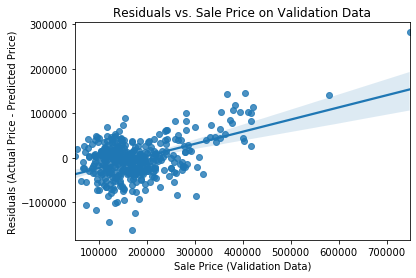

In [31]:
residuals = y_val - y_predicted
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Sale Price (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Validation Data");

Ideally, we would see a horizontal line of points at 0 (perfect prediction!). The next best thing would be a homogenous set of points centered at 0. 

But alas, our simple model is probably too simple. The most expensive homes are systematically more expensive than our prediction.

<!-- BEGIN QUESTION -->

## Question 5d

What changes could you make to your linear model to improve its accuracy and lower the validation error? Suggest at least two things you could try in the cell below, and carefully explain how each change could potentially improve your model's accuracy.

<!--
BEGIN QUESTION
name: q5d
points: 2
manual: True
-->

I would try increasing the model complexity by adding a relevant feature. This could potentially improve my model accuracy because it reduces bias and increases model variance. This is because more parameters would mean more possible combinations of parameters and thus increased variance. The catch is that test error might incerase if the increase in model variance surpasses the decrease in bias. This is when regularization (penalizing larger weighted features) would be useful in decreasing variance.

I would also try cross validation, spliting the training data into partitions and using one split as the validation set. Repeating this a number of times to find the validation error or the average of errors and selecting the model with the lowest error. This process helps prevent overfitting and help with the variance.

<!-- END QUESTION -->



# Part 4: More Feature Selection and Engineering

The linear model that you created failed to produce accurate estimates of the observed housing prices because the model was too simple. The goal of the next few parts is to guide you through the iterative process of specifying, fitting, and analyzing the performance of more complex linear models used to predict prices of houses in Ames, Iowa. Additionally, you will have the opportunity to choose your own features and create your own regression model!

In this section, we identify two more features of the dataset that will increase our linear regression model's accuracy. Additionally, we will implement one-hot encoding so that we can include binary and categorical variables in our improved model.

We've used a slightly modified data cleaning pipeline from the first half of the assignment to prepare the training data. This data is stored in `ames_train_cleaned.csv`. It consists of 1998 observations and 83 features (we added TotalBathrooms from the first half of the assignment). 

In [32]:
training_data = pd.read_csv("ames_train_cleaned.csv")

## Question 6: Neighborhood vs Sale Price

First, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.

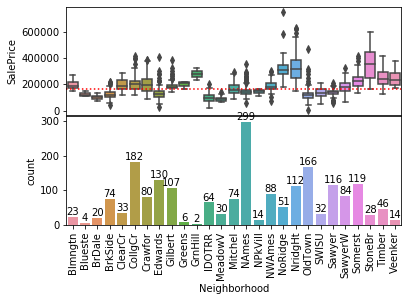

In [33]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

<!-- BEGIN QUESTION -->

## Question 6a

Based on the plot above, what can be said about the relationship between the houses' sale prices and their neighborhoods?

<!--
BEGIN QUESTION
name: q6a
points: 1
manual: True
-->

There is not a clear relationship between the house sale price and their neighborhoods. Neighborhoods with high counts have mean saleprices that are both high and low and that's also the case for neighborhoods with low counts. Meaning, there is a lot of variation in prices across the different neighborhoods. Additionally, the count is different for every neighborhood, some neighborhoods have a much higher count than others. It's hard to establish a clear relationship based off of that.

<!-- END QUESTION -->

## Question 6b

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods". We won't mark the other neighborhoods.

Write a function that returns list of the top n most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `SalePrice`.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [34]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = (training_data.groupby("Neighborhood").agg({"SalePrice" : metric}).sort_values("SalePrice", ascending = False ).index[:n])
    return list(neighborhoods)

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

In [35]:
grader.check("q6b")

All tests passed!

## Question 6c

We now have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`.  Write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.

**Hint:** [`pd.Series.astype`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.astype.html) may be useful for converting True/False values to integers.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q6c
points: 1
-->

In [36]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data["in_rich_neighborhood"] = data["Neighborhood"].isin(neighborhoods).astype('int32')
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

In [37]:
grader.check("q6c")

All tests passed!

## Question 7: Fireplace Quality

In the following question, we will take a closer look at the Fireplace_Qu feature of the dataset and examine how we can incorporate categorical features into our linear model.

## Question 7a

Let's see if our data set has any missing values.  Create a Series object containing the counts of missing values in each of the columns of our data set, sorted from greatest to least.  The Series should be indexed by the variable names.  For example, `missing_counts.loc['Fireplace_Qu']` should return 975.

**Hint:** [`pandas.DataFrame.isnull`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html) may help here.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q7a
points: 1
-->

In [38]:
missing_counts =  training_data.isnull().sum().sort_values(ascending = False)
missing_counts


Pool_QC            1991
Misc_Feature       1922
Alley              1865
Fence              1607
Fireplace_Qu        975
                   ... 
Low_Qual_Fin_SF       0
2nd_Flr_SF            0
1st_Flr_SF            0
Central_Air           0
Order                 0
Length: 84, dtype: int64

In [39]:
grader.check("q7a")

All tests passed!

It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```


## Question 7b

An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  Write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it should replace each abbreviated condition with its full word.  For example, `'TA'` should be changed to `'Average'`.  Hint: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here, for both strings and NAs.

*The provided tests check that part of your answer is correct, but they are not fully comprehensive.*

<!--
BEGIN QUESTION
name: q7b
points: 2
-->

In [40]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    dic = {"Ex":"Excellent", "Gd":"Good", "TA":"Average", "Fa": "Fair", "Po": "Poor",}
    data['Fireplace_Qu'] = data['Fireplace_Qu'].replace(dic)
    data['Fireplace_Qu'] = data['Fireplace_Qu'].fillna(value="No Fireplace")
    return data
    
training_data = fix_fireplace_qu(training_data)

In [41]:
grader.check("q7b")

All tests passed!

In [42]:
training_data['Fireplace_Qu']

0               Good
1       No Fireplace
2       No Fireplace
3            Average
4            Average
            ...     
1993         Average
1994    No Fireplace
1995    No Fireplace
1996    No Fireplace
1997         Average
Name: Fireplace_Qu, Length: 1998, dtype: object

### An Important Note on One Hot Encoding <a name="important_note"></a>

Unfortunately, simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical variable, we will have to one-hot-encode the data using `DictVectorizer` from Lab 6. Note that we dropped the first one-hot-encoded column. For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).

In [43]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form Fireplace_Qu=QUALITY
    """
    vec_enc = DictVectorizer()
    vec_enc.fit(data[['Fireplace_Qu']].to_dict(orient='records'))
    fireplace_qu_data = vec_enc.transform(data[['Fireplace_Qu']].to_dict(orient='records')).toarray()
    fireplace_qu_cats = vec_enc.get_feature_names()
    fireplace_qu = pd.DataFrame(fireplace_qu_data, columns=fireplace_qu_cats)
    data = pd.concat([data, fireplace_qu], axis=1)
    data = data.drop(columns=fireplace_qu_cats[0])
    return data

In [44]:
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='Fireplace_Qu').head(10)

,Fireplace_Qu,Fireplace_Qu=Excellent,Fireplace_Qu=Fair,Fireplace_Qu=Good,Fireplace_Qu=No Fireplace,Fireplace_Qu=Poor
0,Good,0.0,0.0,1.0,0.0,0.0
1,No Fireplace,0.0,0.0,0.0,1.0,0.0
2,No Fireplace,0.0,0.0,0.0,1.0,0.0
3,Average,0.0,0.0,0.0,0.0,0.0
4,Average,0.0,0.0,0.0,0.0,0.0
5,Good,0.0,0.0,1.0,0.0,0.0
6,No Fireplace,0.0,0.0,0.0,1.0,0.0
7,Average,0.0,0.0,0.0,0.0,0.0
8,No Fireplace,0.0,0.0,0.0,1.0,0.0
9,Good,0.0,0.0,1.0,0.0,0.0


# Part 5: Improved Linear Models

In this section, we will create linear models that produce more accurate estimates of the housing prices in Ames than the model created in the first half of this assgnment, but at the expense of increased complexity.

## Question 8: Adding Covariates to our Model

It's finally time to fit our updated linear regression model using the ordinary least squares estimator! Our new model consists of the linear model from the first half of this assignment, with the addition of the our newly created `in_rich_neighborhood` variable and our one-hot-encoded fireplace quality variables:

$$\begin{align}
\text{SalePrice} & = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + 
\theta_3 \cdot \text{TotalBathrooms} + \theta_4 \cdot \text{in_rich_neighborhood} + \\
& \quad \: \theta_5 \cdot \text{Fireplace_Qu=Excellent} + \theta_6 \cdot \text{Fireplace_Qu=Fair} + \theta_7 \cdot \text{Fireplace_Qu=Good} + \\
& \quad \: \theta_8 \cdot \text{Fireplace_Qu=No Fireplace} + \theta_9 \cdot \text{Fireplace_Qu=Poor}
\end{align}$$

<!-- BEGIN QUESTION -->

## Question 8a

Although the fireplace quality variable that we explored in Question 2 has six categories, only five of these categories' indicator variables are included in our model. Is this a mistake, or is it done intentionally? Why?

<!--
BEGIN QUESTION
name: q8a
points: 1
manual: True
-->

This is done intentionally because the variable that is dropped is redundant and thus would make the columns linearly dependent. Dropping one of the indicator variables would ensure full rank and linear independence for invertability.

<!-- END QUESTION -->



We still have a little bit of work to do prior to esimating our linear regression model's coefficients. Instead of having you go through the process of selecting the pertinent convariates and creating a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for our linear model again, we will provide the necessary code from the first half of this assignment. However, we will now use cross validation to help validate our model instead of explicitly splitting the data into a training and validation set.

First, we will re-import the data.

In [45]:
training_data = pd.read_csv("ames_train_cleaned.csv")

Next, we will implement a reusable pipeline that selects the required variables in our data and splits our covariates and response variable into a matrix and a vector, respectively.

In [46]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'Fireplace_Qu=Excellent',
                          'Fireplace_Qu=Fair',
                          'Fireplace_Qu=Good',
                          'Fireplace_Qu=No Fireplace',
                          'Fireplace_Qu=Poor'
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

We then process our training set using our data cleaning pipeline.

In [47]:
# Pre-process the training data
# Our functions make this very easy!
X_train_gm, y_train_gm = process_data_gm(training_data)
X_train_gm.head()

,Gr_Liv_Area,Garage_Area,TotalBathrooms,in_rich_neighborhood,Fireplace_Qu=Excellent,Fireplace_Qu=Fair,Fireplace_Qu=Good,Fireplace_Qu=No Fireplace,Fireplace_Qu=Poor
0,1656,528,2.0,0,0.0,0.0,1.0,0.0,0.0
1,896,730,1.0,0,0.0,0.0,0.0,1.0,0.0
2,1329,312,1.5,0,0.0,0.0,0.0,1.0,0.0
3,2110,522,3.5,0,0.0,0.0,0.0,0.0,0.0
4,1629,482,2.5,0,0.0,0.0,0.0,0.0,0.0


Finally, we initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. We set the `fit_intercept=True` to ensure that the linear model has a non-zero intercept.

In [48]:
from sklearn import linear_model as lm

linear_model_gm = lm.LinearRegression(fit_intercept=True)

After a little bit of work, it's finally time to fit our updated linear regression model. The cell below estimates the model and then uses it to compute the fitted value of `SalePrice` over the training data.

In [49]:
# Fit the model
linear_model_gm.fit(X_train_gm, y_train_gm)

# Compute the fitted and predicted values of SalePrice
y_fitted_gm = linear_model_gm.predict(X_train_gm)

Let's assess the performance of our new linear regression model using the Root Mean Squared Error function from earlier in this assignment.

In [50]:
training_error_gm = rmse(y_fitted_gm, y_train_gm)
print("Training RMSE: {}".format(training_error_gm))

Training RMSE: 40118.93633164243


A slighlty modified version of the `cross_validate_rmse` function from Lecture 16 is provided below.

In [51]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

## Question 8b

Use the `cross_validate_rmse` function to calculate the cross validation error in the cell below.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to a non-negative number.*

<!--
BEGIN QUESTION
name: q8b
points: 1
-->

In [52]:
cv_error_gm = cross_validate_rmse(linear_model_gm, X_train_gm, y_train_gm)
print("Cross Validation RMSE: {}".format(cv_error_gm))

Cross Validation RMSE: 40346.2672678042


In [53]:
grader.check("q8b")

All tests passed!

# Part 6: Open-Response

The following part is purposefully left nearly open-ended.  The Ames data in your possession comes from a larger data set.  Your goal is to provide a linear regression model that accurately predicts the prices of the held-out homes, measured by root mean square error. 

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in public test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{# of houses}}}$$

Perfect prediction of house prices would have a score of 0, so you want your score to be as low as possible!

### Grading Scheme

Your grade for Question 9 will be based on your training RMSE and test RMSE. You will receive full credit for a model that has a training RMSE less than 38k and a test RMSE less than 39k.


### One Hot Encoding

If you choose to include more categorical features in your model, you'll need to one-hot-encode each one. Remember that if a categorical variable has a unique value that is present in the training set but not in the test set, one-hot-encoding this variable will result in different outputs for the training and test sets (different numbers of one-hot columns). Watch out for this! Feel free to look back at how we [one-hot-encoded `Fireplace_Qu`](#important_note).

To generate all possible categories for a categorical variable, we suggest reading through `codebook.txt` or finding the values programmatically across both the training and test datasets.

## Question 9: Your Own Linear Model

Just as in the guided model above, you should encapsulate as much of your workflow into functions as possible. Below, we have initialized `final_model` for you. Your job is to select better features and define your own feature engineering pipeline in `process_data_fm`. We recommend using cross validation to help inform your feature selection process.

To evaluate your model, we will process training data using your `process_data_fm`, fit `final_model` with this training data, and compute the training RMSE. Then, we will process the test data with your `process_data_fm`, use `final_model` to predict sale prices for the test data, and compute the test RMSE. See below for an example of the code we will run to grade your model:

```
training_data = pd.read_csv('ames_train_cleaned.csv')
test_data = pd.read_csv('ames_test_cleaned.csv')

X_train, y_train = process_data_fm(training_data)
X_test, y_test = process_data_fm(test_data)

final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)
```

**Note:** It is your duty to make sure that all of your feature engineering and selection happens in `process_data_fm`, and that the function performs as expected without errors. We will **NOT** accept regrade requests that require us to go back and run code that require typo/bug fixes.

**Hint:** Some features may have missing values in the test set but not in the training set. Make sure `process_data_fm` handles missing values appropriately for each feature!
<!--
BEGIN QUESTION
name: q9
points: 4
-->

In [54]:
final_model = lm.LinearRegression(fit_intercept=True) # No need to change this!

def process_data_fm(data):
    list(test_data.select_dtypes(include=[np.number]).columns.values)
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data,'SalePrice','Gr_Liv_Area','Garage_Area','in_rich_neighborhood','Lot_Area','Year_Built','Fireplaces','Overall_Qual')
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    X = X.fillna(0)
    X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 0.00001)
    return X, y

In [55]:
grader.check("q9")

All tests passed!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [56]:
grader.check_all()

q1:

    All tests passed!
    

q2a:

    All tests passed!
    

q3:

    All tests passed!
    

q4a:

    All tests passed!
    

q4b:

    All tests passed!
    

q5a:

    All tests passed!
    

q5b:

    All tests passed!
    

q5c:

    All tests passed!
    

q6b:

    All tests passed!
    

q6c:

    
    0 of 1 tests passed
    
    
    Tests failed:
    
           ./tests/q6c.py

Test result:
Trying:
    sum(training_data.loc[:, 'in_rich_neighborhood']) == 191
Expecting:
    True
**********************************************************************
Line 1, in ./tests/q6c.py 0
Failed example:
    sum(training_data.loc[:, 'in_rich_neighborhood']) == 191
Exception raised:
    Traceback (most recent call last):
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2897, in get_loc
        return self._engine.get_loc(key)
      File "pandas/_libs/index.pyx", line 107, in pandas._libs.index.IndexEngine.get_loc
      File "pandas/_libs/index.pyx", line 131, in pandas._libs.index.IndexEngine.get_loc
      File "pandas/_libs/hashtable_class_helper.pxi", line 1607, in pandas._libs.hashtable.PyObjectHashTable.get_item
      File "pandas/_libs/hashtable_class_helper.pxi", line 1614, in pandas._libs.hashtable.PyObjectHashTable.get_item
    KeyError: 'in_rich_neighborhood'

    During handling of the above exception, another exception occurred:

    Traceback (most recent call last):
      File "/srv/conda/envs/data100/lib/python3.7/doctest.py", line 1329, in __run
        compileflags, 1), test.globs)
      File "<doctest ./tests/q6c.py 0[0]>", line 1, in <module>
        sum(training_data.loc[:, 'in_rich_neighborhood']) == 191
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/indexing.py", line 1418, in __getitem__
        return self._getitem_tuple(key)
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/indexing.py", line 805, in _getitem_tuple
        return self._getitem_lowerdim(tup)
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/indexing.py", line 929, in _getitem_lowerdim
        section = self._getitem_axis(key, axis=i)
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/indexing.py", line 1850, in _getitem_axis
        return self._get_label(key, axis=axis)
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/indexing.py", line 160, in _get_label
        return self.obj._xs(label, axis=axis)
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/generic.py", line 3729, in xs
        return self[key]
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/frame.py", line 2995, in __getitem__
        indexer = self.columns.get_loc(key)
      File "/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2899, in get_loc
        return self._engine.get_loc(self._maybe_cast_indexer(key))
      File "pandas/_libs/index.pyx", line 107, in pandas._libs.index.IndexEngine.get_loc
      File "pandas/_libs/index.pyx", line 131, in pandas._libs.index.IndexEngine.get_loc
      File "pandas/_libs/hashtable_class_helper.pxi", line 1607, in pandas._libs.hashtable.PyObjectHashTable.get_item
      File "pandas/_libs/hashtable_class_helper.pxi", line 1614, in pandas._libs.hashtable.PyObjectHashTable.get_item
    KeyError: 'in_rich_neighborhood'

    
    
    
    

q7a:

    
    0 of 1 tests passed
    
    
    Tests failed:
    
           ./tests/q7a.py

Test result:
Trying:
    set(missing_counts.index.values) == set(training_data.columns.values)
Expecting:
    True
**********************************************************************
Line 1, in ./tests/q7a.py 2
Failed example:
    set(missing_counts.index.values) == set(training_data.columns.values)
Expected:
    True
Got:
    False

    
    
    
    

q7b:

    All tests passed!
    

q8b:

    All tests passed!
    

q9:

    All te

## Submission

Make sure you have run all cells in your notebook in order before     running the cell below, so that all images/graphs appear in the output. The cell below will generate     a zipfile for you to submit. **Please save before exporting!**

In [57]:
# Save your notebook first, then run this cell to export your submission.
grader.export()